In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context="poster")
mainpath = '/Users/jorgetil/Astro/python_tuto/student_workshop_17'

# Unsupervised Classification

### Clustering on light-curve features

The Lincoln Near Earth Asteroid Research (LINEAR) project, in existance since 1998, is designed to discover and track near-earth asteroids. Its archive contains several million images of the sky, and its combination of sensitivity and sky coverage has made it a valuable resource to study time-domain astronomy, including variable stars. astroML has two functions relating to the LINEAR sample: fetch_LINEAR_sample() fetches light curves for over 7000 variable stars. 

http://www.ll.mit.edu/mission/space/linear/

<img src="fig_LINEAR_LS_11.png">

In [4]:
from astroML.datasets import fetch_LINEAR_sample, fetch_LINEAR_geneva

data = fetch_LINEAR_sample()
descrip = fetch_LINEAR_geneva()
data_ids = data.ids
attributes = ['gi', 'logP', 'ug', 'iK', 'JK', 'amp', 'skew']
df_data = pd.DataFrame(descrip[attributes], columns=attributes, index=descrip['LINEARobjectID'])
df_data = df_data[df_data.amp > 0].sample(2000)

In [5]:
print 'How many LC?', len(data_ids)
df_data.describe()

How many LC? 7010


,gi,logP,ug,iK,JK,amp,skew
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.406018,-0.370259,1.305379,1.249146,0.372304,0.569025,0.413865
std,0.479774,0.208209,0.349699,0.478443,0.203585,0.189299,1.339849
min,-1.971000,-1.315577,-1.578000,0.174000,-0.477000,0.162000,-1.697000
25%,0.095750,-0.517747,1.147000,0.923000,0.231000,0.417000,-0.396000
50%,0.312500,-0.351415,1.197000,1.164500,0.348000,0.528000,0.150000
75%,0.671000,-0.234014,1.326000,1.480250,0.513000,0.698000,0.748250
max,2.615000,1.529000,2.533000,5.398000,1.189000,1.338000,12.665000


Lets extract features from the LC using FATS

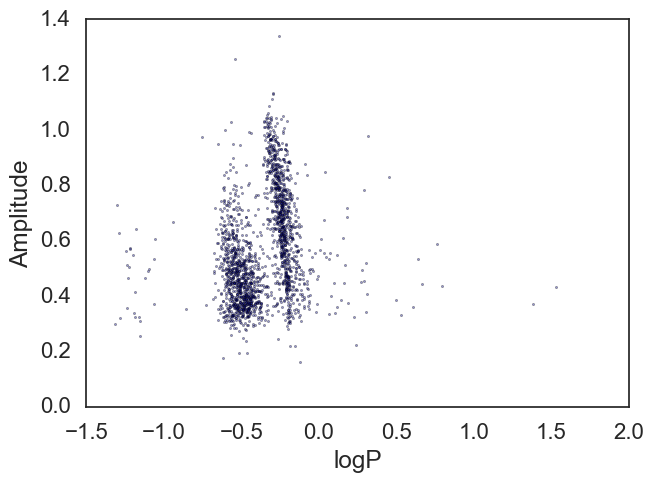

In [6]:
plt.figure(figsize=(7,5))
#plt.plot(np.log10(feats_DF['PeriodLS']), feats_DF['Amplitude'], '.k')
plt.scatter(df_data['logP'], df_data['amp'], c='darkblue', marker='.', s=10, alpha =.4)
plt.xlabel('logP')
#plt.xlim(-1,1)
#plt.ylim(0,2)
plt.ylabel('Amplitude')
plt.show()

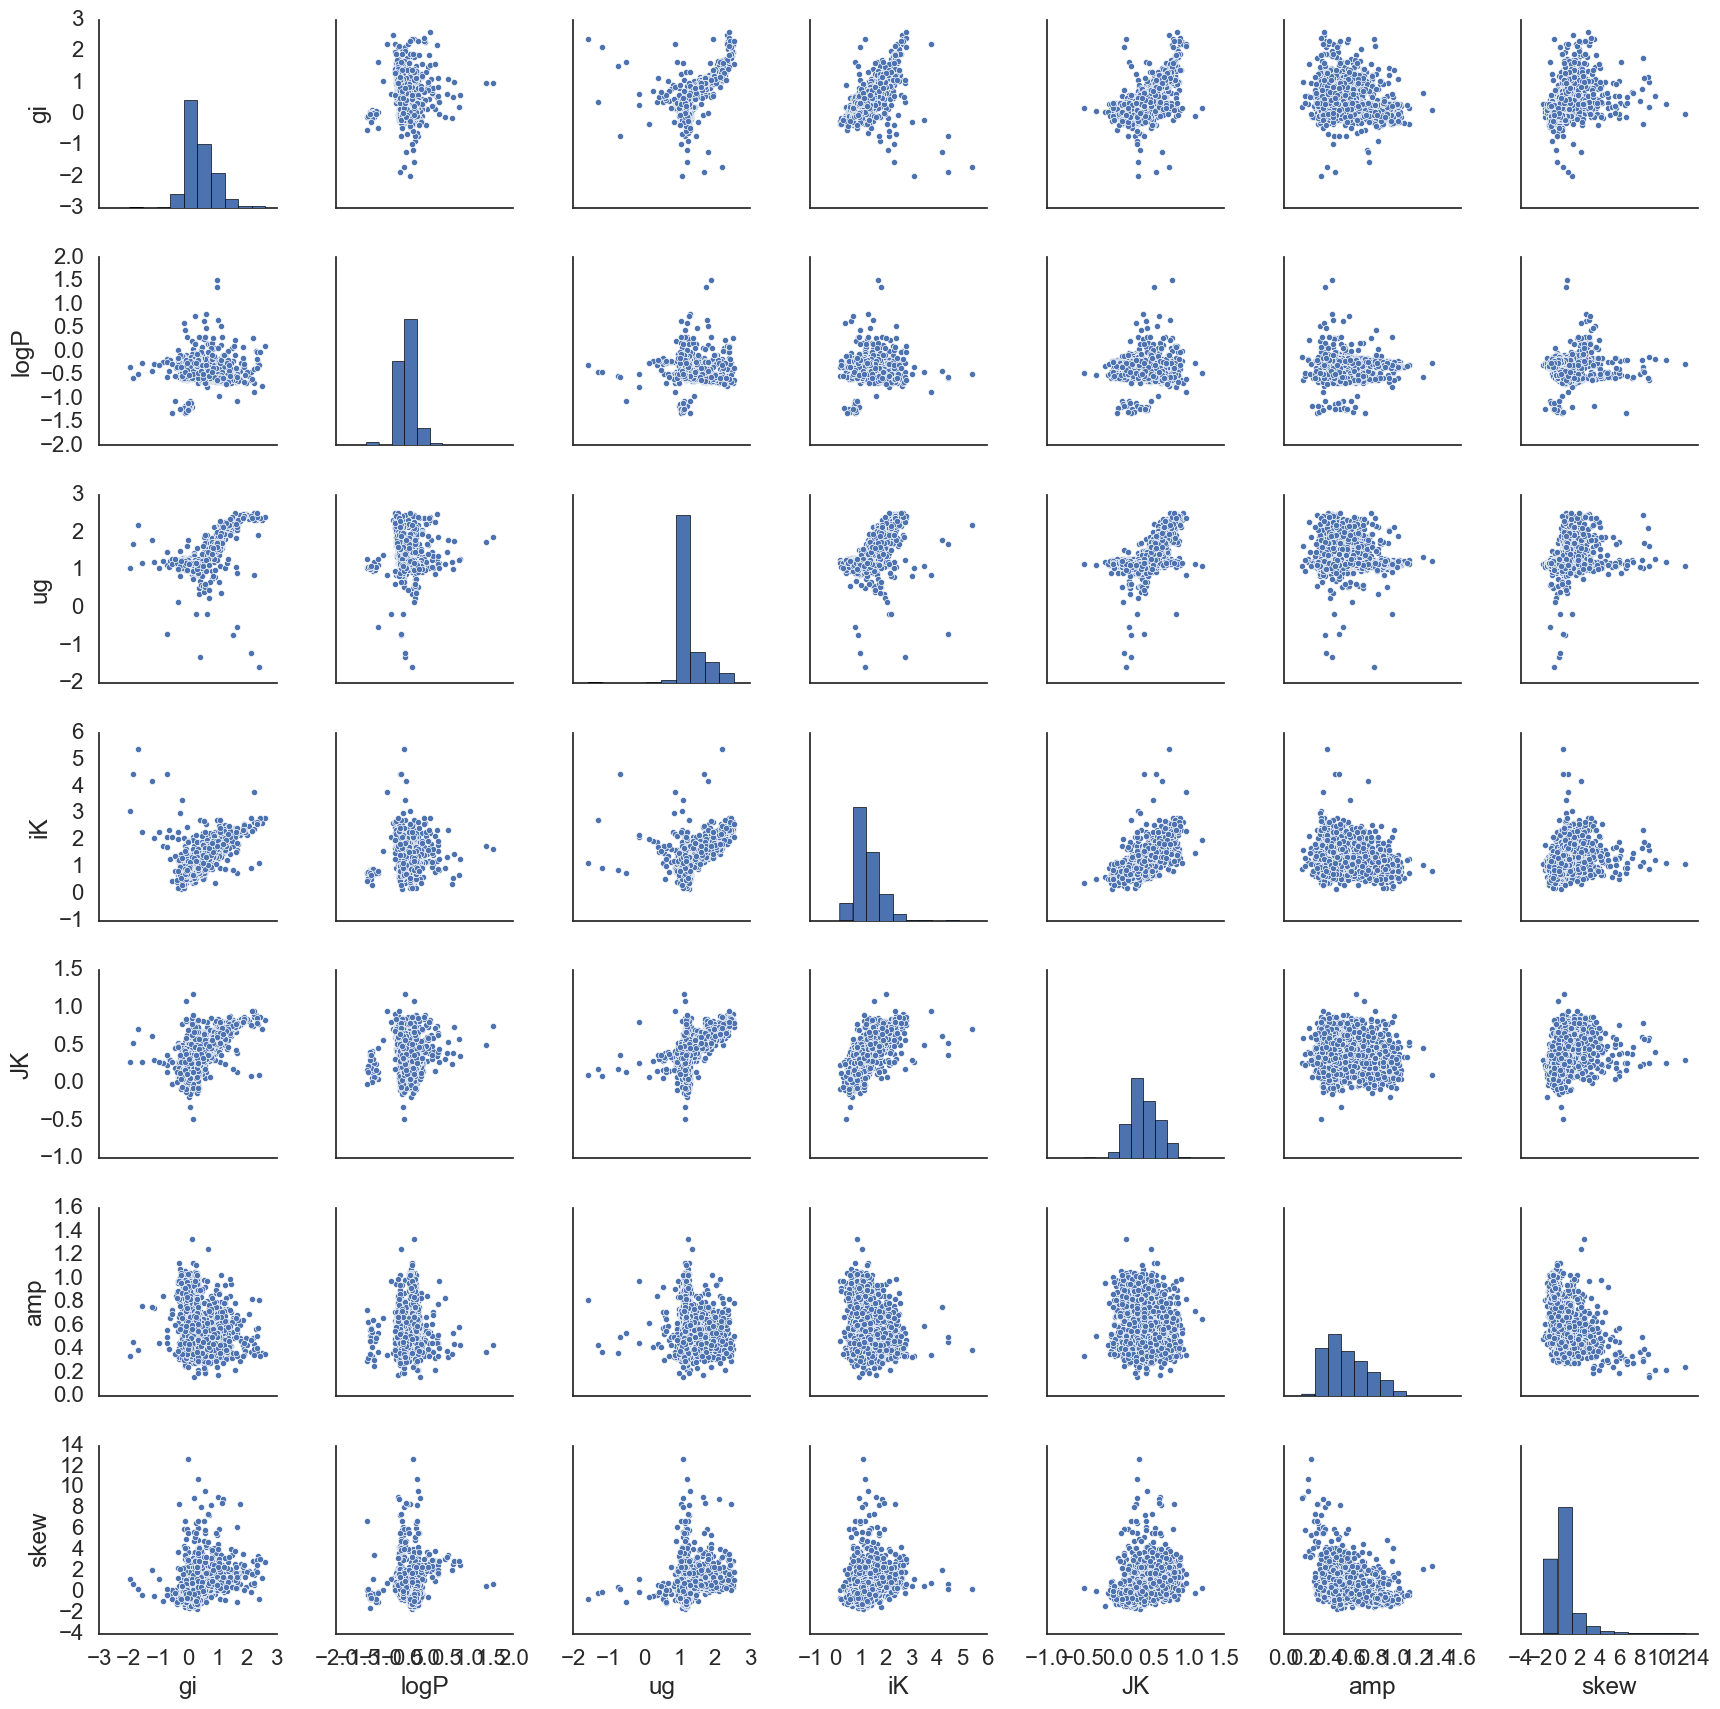

In [7]:
sns.pairplot(df_data)
plt.show()

### Clustering algorithms
<img src="sphx_glr_plot_cluster_comparison_0011.png">

### K-Mean Clustering

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.
The k-means algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space.

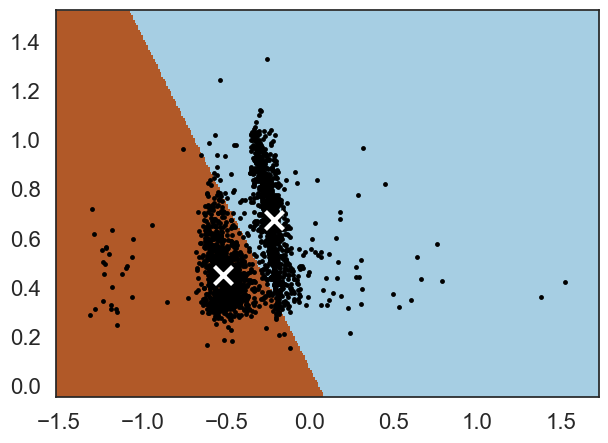

In [10]:
from sklearn.cluster import KMeans

X_ = df_data[['logP','amp']].values

kmeans = KMeans(n_clusters=2, init='k-means++').fit(X_)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_[:, 0].min() - .2, X_[:, 0].max() + .2
y_min, y_max = X_[:, 1].min() - .2, X_[:, 1].max() + .2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_[:, 0], X_[:, 1], 'k.', markersize=7)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())
plt.show()

###  DBSCAN

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


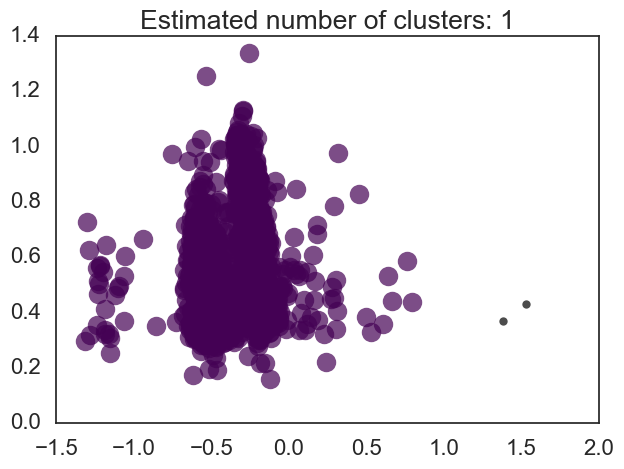

In [11]:
from sklearn.cluster import DBSCAN

db = DBSCAN().fit(X_)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(7,5))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14, alpha=.7)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6, alpha=.7)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

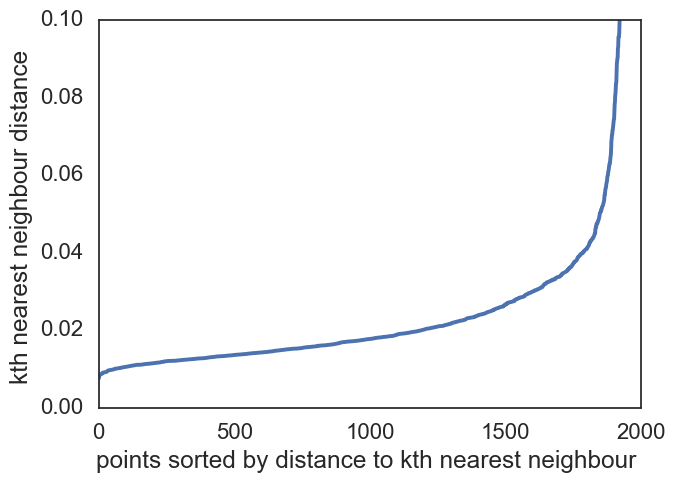

In [14]:
from sklearn.neighbors import NearestNeighbors

K_neigh = 10
radius = .5
neigh = NearestNeighbors(K_neigh, radius)
neigh.fit(X_)

dist, _ = neigh.kneighbors(X_)
larger_dist = dist[:, -1]
larger_dist.sort()

plt.figure(figsize=(7,5))
plt.clf()
plt.plot (larger_dist)
plt.xlabel("points sorted by distance to kth nearest neighbour ")
plt.ylabel("kth nearest neighbour distance ")
plt.ylim(0., .10)
plt.show()

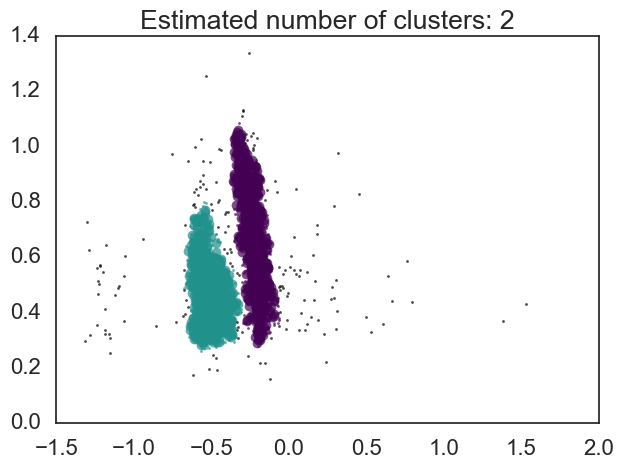

In [17]:
db = DBSCAN(eps=.035, min_samples=10).fit(X_)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(7,5))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=7, alpha=.7)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=2, alpha=.7)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()